# Feature Engineering & Modelling for Amazon Product Review Sentiment Analysis

This notebook demonstrates the feature engineering and model training process for sentiment analysis of Amazon product reviews.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from scipy.sparse import hstack

In [2]:
# Load the dataset from a parquet file
df_reviews_raw = pd.read_parquet("C:/SourceCode/sentiment_amazon_review/dataset/sample_amazon_product_review_data_20240627_152732.parquet")
df_reviews_raw.head(3)

,asin,helpful_vote,parent_asin,rating,text,timestamp,title,user_id,verified_purchase,category,has_image
0,B09WSVFSGJ,8,B09WSVFSGJ,1.0,Don’t get it! My hair is falling out! PLEASE...,1660780044308,My hair is falling out! DON’T get it!,AHGCCTL7DBBD7FK4RFYAJS53BGOA,True,All_Beauty,False
1,B08YWJP9PJ,0,B08YWJP9PJ,1.0,The curved ends on almost all of these is not ...,1619087472258,Poor design,AETGCWXC47MSMK6B2TLZ44KCFJZQ,True,All_Beauty,False
2,B076BTRBTN,0,B076BTRBTN,1.0,Crappy & unusable.,1581758635824,Don't waste your money,AEZBFZHVLG7CMLFKRNEDYYYMEYZQ,True,All_Beauty,False


Remove records where the review text is missing to ensure the dataset is clean and usable for text analysis.

In [3]:
# Remove records where the review text is missing
df_reviews_raw = df_reviews_raw[df_reviews_raw["text"].notna()]

Randomly sample 100,000 records from the dataset to create a manageable subset for training and testing.

In [4]:
# Randomly sample 100,000 records from the dataset for training and testing
# df_sample = df_reviews_raw.sample(n=400000, random_state=42)
df_sample = df_reviews_raw

## Feature Engineering

### New Features

In [5]:
# Create a new column for review length
df_sample['review_length'] = df_sample['text'].str.len()

In [6]:
# Convert the timestamp to datetime
df_sample['timestamp'] = pd.to_datetime(df_sample['timestamp'].astype('int64'), unit='ms')

In [7]:
# Extract the review year and month
df_sample['review_year'] = df_sample['timestamp'].dt.year
df_sample['review_month'] = df_sample['timestamp'].dt.month

Sentiment Analysis: Uses TextBlob to calculate the sentiment polarity of the review text and adds it as a feature.

In [8]:
# !pip install textblob

In [9]:
# Calculate the sentiment polarity of the review text using TextBlob and add it as a new feature
df_sample['sentiment_score'] = df_sample['text'].apply(lambda text: TextBlob(text).sentiment.polarity)

### Feature Selection & Target Encoding

Target Encoding: 
- Sentiment Label: Map numerical ratings to sentiment labels (Negative, Neutral, Positive)

In [10]:
# Create a new target column based on rating sentiment
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    elif rating in [4, 5]:
        return 'Positive'
    else:
        return 'Unknown'

df_sample['sentiment_label'] = df_sample['rating'].apply(map_rating_to_sentiment)

Target Encoding: Label Encoding
- Encode the sentiment labels to numerical values starting from 0.

In [11]:
# Encode the new target labels so that they start from 0
df_sample['sentiment_label'] = df_sample['rating'].apply(map_rating_to_sentiment)
label_encoder = LabelEncoder()
df_sample['sentiment_label_encoded'] = label_encoder.fit_transform(df_sample['sentiment_label'])

Feature and Target Definition
- Define the features (text and additional features) and the target variable for model training.

In [12]:
# Define the features and encoded target variable
X_text = df_sample['text']
X_additional = df_sample[['review_length', 'helpful_vote', 'sentiment_score', 'verified_purchase', 'category', 'has_image']]
y = df_sample['sentiment_label_encoded']

### Data Splitting

Split the data into training and testing sets to evaluate model performance on unseen data. Below isfor 30K training 200K test set for quick results retrieval.

In [13]:
# Split the data into training and testing sets
X_train_text, X_test_text, X_train_additional, X_test_additional, y_train, y_test = train_test_split(
    X_text, X_additional, y, test_size=0.2, random_state=42)

## Preprocessing pipeline

Define separate preprocessing pipelines for text, numeric, and categorical features.

In [14]:
# Define preprocessing pipelines

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=10000))])  # Limit TF-IDF features to 10,000

numeric_features = ['review_length', 'helpful_vote', 'sentiment_score']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['verified_purchase', 'category', 'has_image']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

## Model Training and Hyperparameter Tuning

Define the machine learning models to be evaluated: Logistic Regression and Random Forest.

In [15]:
# Define the models to be evaluated
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, nthread=-1)
}

Define the parameter grid for hyperparameter tuning using GridSearchCV.

In [16]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter for logistic regression
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],  # Number of trees in the forest
        'model__max_depth': [10, 20, None]  # Maximum depth of the trees
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],  # Number of boosting rounds
        'model__max_depth': [3, 6, 10],  # Maximum depth of trees
        'model__learning_rate': [0.01, 0.1, 0.2]  # Step size shrinkage
    }
}

Perform hyperparameter tuning using GridSearchCV for each model and store the best models.

In [17]:
import pickle

# Define a custom function to combine text and additional features
def combine_features(text_features, 
                     additional_features, 
                     text_transformer_path = "", 
                     numeric_transformer_path = "", 
                     categoric_transformer_path = ""):
    if text_transformer_path == "":
        text_transformed = text_transformer.fit_transform(text_features)
        with open('tfidf_vectorizer.pkl', 'wb') as file:
            pickle.dump(text_transformer, file)
    else:
        with open(text_transformer_path, 'rb') as file:
            loaded_vectorizer = pickle.load(file)
        text_transformed = loaded_vectorizer.transform(text_features)
    
    n_features = len(text_transformer.get_feature_names_out())
    print(f"Number of features in the text vectorizer: {n_features}")
    
    if numeric_transformer_path == "":
        numeric_transformed = numeric_transformer.fit_transform(additional_features[numeric_features])
        with open('numeric_transformer.pkl', 'wb') as file:
            pickle.dump(numeric_transformer, file)
    else:
        with open(numeric_transformer_path, 'rb') as file:
            loaded_numeric_transformer = pickle.load(file)
        numeric_transformed = loaded_numeric_transformer.transform(additional_features[numeric_features])

        
    if categoric_transformer_path == "":
        categorical_transformed = categorical_transformer.fit_transform(additional_features[categorical_features])
        with open('categoric_transformer.pkl', 'wb') as file:
            pickle.dump(categorical_transformer, file)
    else:
        with open(categoric_transformer_path, 'rb') as file:
            loaded_categoric_transformer = pickle.load(file)
        categorical_transformed = loaded_categoric_transformer.transform(additional_features[categorical_features])        
    

    combined_features = hstack((text_transformed, numeric_transformed, categorical_transformed))
    return combined_features

# Define a function to fit the model
def fit_model(pipe, X_train_text, X_train_additional, y_train):
    X_train_combined = combine_features(X_train_text, X_train_additional)
    grid_search = GridSearchCV(pipe, param_grid[model_name], cv=3, n_jobs=-1)
    grid_search.fit(X_train_combined, y_train)
    return grid_search

In [18]:
import time

# Perform hyperparameter tuning using GridSearchCV
best_models = {}
for model_name, model in models.items():
    start_time = time.time()  # Start timing
    
    # Create a pipeline without preprocessing, as it's handled separately
    pipe = Pipeline(steps=[('model', model)])
    
    # Fit the model and find best parameters
    grid_search = fit_model(pipe, X_train_text, X_train_additional, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    
    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Convert elapsed time to minutes and seconds
    minutes = int(elapsed_time // 60)
    seconds = elapsed_time % 60

    print(f"Time spent on {model_name}: {minutes} minutes and {seconds:.2f} seconds")
    print("-" * 50)  # Print a separator line for better readability    
    
    pickle_file = f"best_{model_name.replace(' ', '_')}_model.pkl"
    with open(pickle_file, 'wb') as file:
        pickle.dump(best_model, file)

Number of features in the text vectorizer: 10000
Best parameters for Logistic Regression: {'model__C': 1}
Time spent on Logistic Regression: 0 minutes and 17.77 seconds
--------------------------------------------------
Number of features in the text vectorizer: 10000
Best parameters for Random Forest: {'model__max_depth': None, 'model__n_estimators': 200}
Time spent on Random Forest: 3 minutes and 16.89 seconds
--------------------------------------------------
Number of features in the text vectorizer: 10000
Best parameters for XGBoost: {'model__learning_rate': 0.2, 'model__max_depth': 6, 'model__n_estimators': 200}
Time spent on XGBoost: 31 minutes and 59.91 seconds
--------------------------------------------------


Now, evaluate the best models on the test set and print the classification report, accuracy, and confusion matrix for each model.

## Evaluate Logistic Regression Model

Number of features in the text vectorizer: 10000


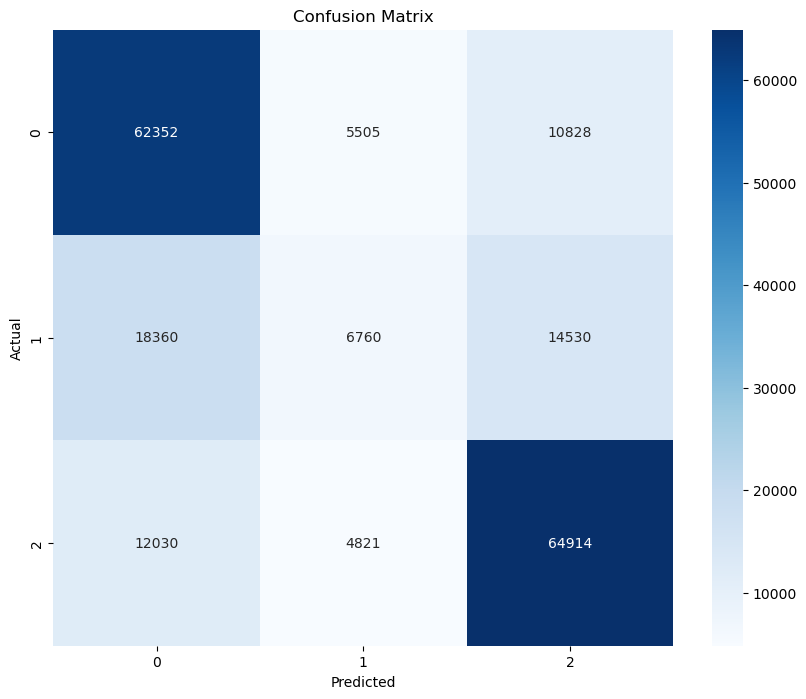

Per-class Metrics:

Negative:
Precision: 0.67
Recall: 0.79
F1-score: 0.73

Neutral:
Precision: 0.40
Recall: 0.17
F1-score: 0.24

Positive:
Precision: 0.72
Recall: 0.79
F1-score: 0.75

Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.79      0.73     78685
     Neutral       0.40      0.17      0.24     39650
    Positive       0.72      0.79      0.75     81765

    accuracy                           0.67    200100
   macro avg       0.60      0.59      0.57    200100
weighted avg       0.64      0.67      0.64    200100



In [19]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

pickle_file = "best_Logistic_Regression_model.pkl"
with open(pickle_file, 'rb') as file:
    loaded_LR_model = pickle.load(file)

X_test_combined = combine_features(X_test_text, 
                                   X_test_additional,
                                   "tfidf_vectorizer.pkl", 
                                   "numeric_transformer.pkl",
                                   "categoric_transformer.pkl")

y_pred = loaded_LR_model.predict(X_test_combined)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate per-class metrics
class_names = ['Negative', 'Neutral', 'Positive']
print("Per-class Metrics:")
for i, class_name in enumerate(class_names):
    true_positive = cm[i, i]
    false_positive = cm[:, i].sum() - true_positive
    false_negative = cm[i, :].sum() - true_positive

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{class_name}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

## Evaluate Random Forest Model

Number of features in the text vectorizer: 10000


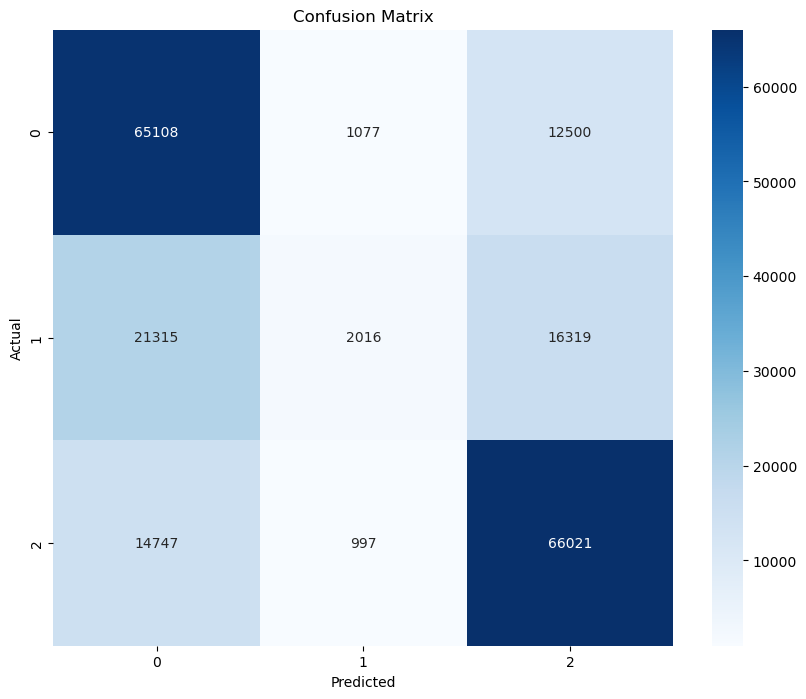

Per-class Metrics:

Negative:
Precision: 0.64
Recall: 0.83
F1-score: 0.72

Neutral:
Precision: 0.49
Recall: 0.05
F1-score: 0.09

Positive:
Precision: 0.70
Recall: 0.81
F1-score: 0.75

Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.83      0.72     78685
     Neutral       0.49      0.05      0.09     39650
    Positive       0.70      0.81      0.75     81765

    accuracy                           0.67    200100
   macro avg       0.61      0.56      0.52    200100
weighted avg       0.64      0.67      0.61    200100



In [20]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

pickle_file = "best_Random_Forest_model.pkl"
with open(pickle_file, 'rb') as file:
    loaded_RF_model = pickle.load(file)

X_test_combined = combine_features(X_test_text, 
                                   X_test_additional,
                                   "tfidf_vectorizer.pkl", 
                                   "numeric_transformer.pkl",
                                   "categoric_transformer.pkl")

y_pred = loaded_RF_model.predict(X_test_combined)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate per-class metrics
class_names = ['Negative', 'Neutral', 'Positive']
print("Per-class Metrics:")
for i, class_name in enumerate(class_names):
    true_positive = cm[i, i]
    false_positive = cm[:, i].sum() - true_positive
    false_negative = cm[i, :].sum() - true_positive

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{class_name}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

## Evaluate XGBoosting Model

In [ ]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

pickle_file = "best_XGBoost_model.pkl"
with open(pickle_file, 'rb') as file:
    loaded_XGB_model = pickle.load(file)

X_test_combined = combine_features(X_test_text, 
                                   X_test_additional,
                                   "tfidf_vectorizer.pkl", 
                                   "numeric_transformer.pkl",
                                   "categoric_transformer.pkl")

y_pred = loaded_XGB_model.predict(X_test_combined)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate per-class metrics
class_names = ['Negative', 'Neutral', 'Positive']
print("Per-class Metrics:")
for i, class_name in enumerate(class_names):
    true_positive = cm[i, i]
    false_positive = cm[:, i].sum() - true_positive
    false_negative = cm[i, :].sum() - true_positive

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{class_name}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

## Feature Importance of Logistic Regression Model


Top 20 important features for Logistic Regression:
            Feature  Importance
9718          waste    3.385621
1869      complaint   -3.125473
5247          loves   -3.011702
5160         little   -3.005427
5242           love   -2.890646
7330         return    2.691707
957             bit   -2.555261
1190          broke    2.539995
9497        useless    2.496821
4700            job   -2.484594
1539          cheap    2.376077
7333      returning    2.371970
1542        cheaply    2.328814
9899          works   -2.275747
4746           junk    2.244861
2581  disappointing    2.234526
7079         refund    2.233411
6105        overall   -2.199484
9226          trash    2.021134
3754        garbage    1.947724


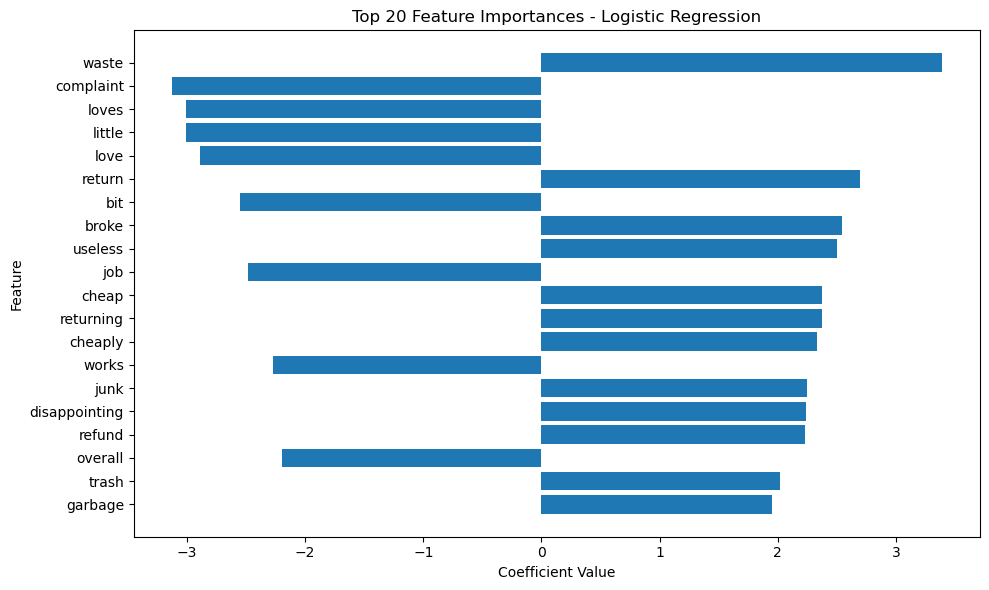

In [22]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved logistic regression model
with open('best_Logistic_Regression_model.pkl', 'rb') as file:
    best_lr_model = pickle.load(file)


with open('tfidf_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

with open('numeric_transformer.pkl', 'rb') as file:
    numeric_transformer = pickle.load(file)
    
with open('categoric_transformer.pkl', 'rb') as file:
    categorical_transformer = pickle.load(file)
    
text_feature_names = vectorizer.get_feature_names_out()


# Get feature names from each transformer
text_feature_names = vectorizer.get_feature_names_out()
numeric_feature_names = numeric_transformer.get_feature_names_out()
categorical_feature_names = categorical_transformer.get_feature_names_out()


feature_names = (
    list(text_feature_names) + 
    list(numeric_feature_names) + 
    list(categorical_feature_names)
)

# Extract coefficients from the logistic regression model
coefficients = best_lr_model.named_steps['model'].coef_[0]

# Check if the lengths match
if len(feature_names) != len(coefficients):
    print("Mismatch in length of feature names and coefficients.")
    print(f"Number of feature names: {len(feature_names)}")
    print(f"Number of coefficients: {len(coefficients)}")
else:
    # Create a DataFrame to display feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefficients
    })

    # Sort the DataFrame by the absolute value of the coefficients
    feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
    feature_importance = feature_importance.sort_values('Absolute Importance', ascending=False)

    # Display the top 20 features
    top_features = feature_importance.head(20)

    # Print the top 20 features
    print("\nTop 20 important features for Logistic Regression:")
    print(top_features[['Feature', 'Importance']])

    # Plot the top 20 features
    plt.figure(figsize=(10, 6))
    plt.title("Top 20 Feature Importances - Logistic Regression")
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Feature Importance of Random Forest


Top 20 important features for Random Forest Model:
               Feature  Importance
10002  sentiment_score    0.070619
10000    review_length    0.027289
3935             great    0.014564
5242              love    0.010135
3870              good    0.007916
10001     helpful_vote    0.007034
2872              easy    0.005572
9899             works    0.005453
5099              like    0.005143
5160            little    0.004725
2520              didn    0.004631
6002                ok    0.004482
2580      disappointed    0.004475
6311           perfect    0.004385
9718             waste    0.004202
4750              just    0.004150
5857              nice    0.003999
1190             broke    0.003943
2519               did    0.003807
5667             money    0.003779


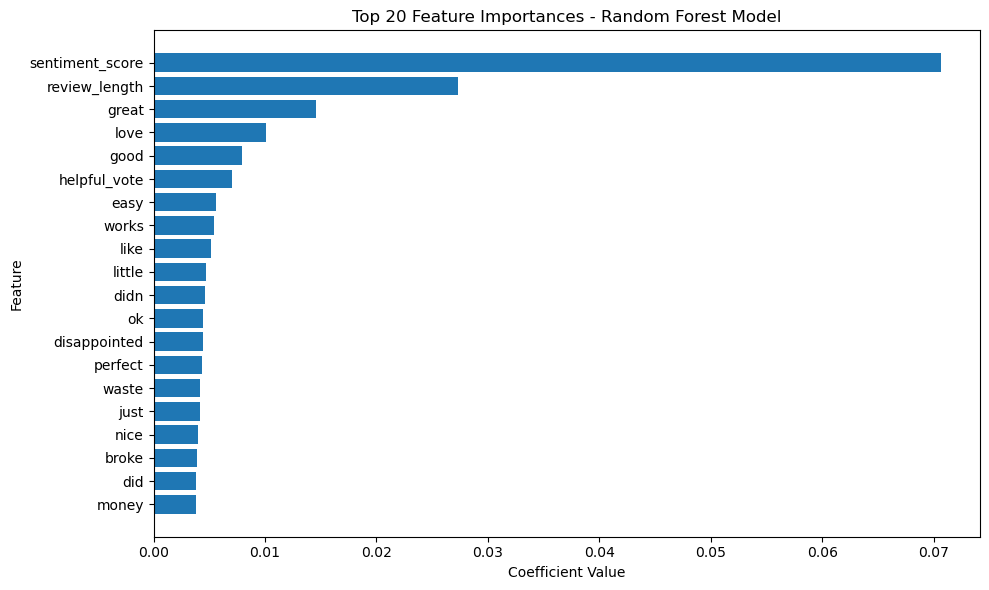

In [23]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved logistic regression model
with open('best_Random_Forest_model.pkl', 'rb') as file:
    best_rf_model = pickle.load(file)


with open('tfidf_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

with open('numeric_transformer.pkl', 'rb') as file:
    numeric_transformer = pickle.load(file)
    
with open('categoric_transformer.pkl', 'rb') as file:
    categorical_transformer = pickle.load(file)
    
text_feature_names = vectorizer.get_feature_names_out()


# Get feature names from each transformer
text_feature_names = vectorizer.get_feature_names_out()
numeric_feature_names = numeric_transformer.get_feature_names_out()
categorical_feature_names = categorical_transformer.get_feature_names_out()


feature_names = (
    list(text_feature_names) + 
    list(numeric_feature_names) + 
    list(categorical_feature_names)
)

# Extract coefficients from the logistic regression model
coefficients = best_rf_model.named_steps['model'].feature_importances_

# Check if the lengths match
if len(feature_names) != len(coefficients):
    print("Mismatch in length of feature names and coefficients.")
    print(f"Number of feature names: {len(feature_names)}")
    print(f"Number of coefficients: {len(coefficients)}")
else:
    # Create a DataFrame to display feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefficients
    })

    # Sort the DataFrame by the absolute value of the coefficients
    feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
    feature_importance = feature_importance.sort_values('Absolute Importance', ascending=False)

    # Display the top 20 features
    top_features = feature_importance.head(20)

    # Print the top 20 features
    print("\nTop 20 important features for Random Forest Model:")
    print(top_features[['Feature', 'Importance']])

    # Plot the top 20 features
    plt.figure(figsize=(10, 6))
    plt.title("Top 20 Feature Importances - Random Forest Model")
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## XGBoost Feature Importance


Top 20 important features for XGBoost Model:
               Feature  Importance
10002  sentiment_score    0.004588
5247             loves    0.004333
9718             waste    0.003470
7332          returned    0.003289
8558           stopped    0.003263
4199            highly    0.003110
1542           cheaply    0.002939
6002                ok    0.002921
7079            refund    0.002784
4746              junk    0.002775
1032              body    0.002758
1190             broke    0.002696
7330            return    0.002677
6003              okay    0.002595
5242              love    0.002569
6311           perfect    0.002529
9226             trash    0.002487
1539             cheap    0.002486
5667             money    0.002478
1869         complaint    0.002397


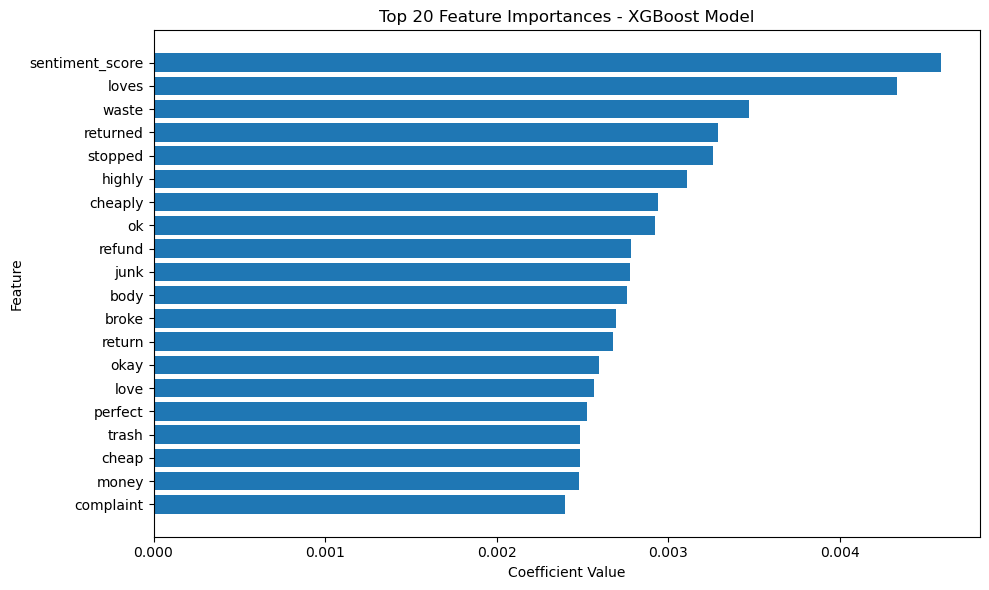

In [24]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved logistic regression model
with open('best_XGBoost_model.pkl', 'rb') as file:
    best_xgb_model = pickle.load(file)


with open('tfidf_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

with open('numeric_transformer.pkl', 'rb') as file:
    numeric_transformer = pickle.load(file)
    
with open('categoric_transformer.pkl', 'rb') as file:
    categorical_transformer = pickle.load(file)
    
text_feature_names = vectorizer.get_feature_names_out()


# Get feature names from each transformer
text_feature_names = vectorizer.get_feature_names_out()
numeric_feature_names = numeric_transformer.get_feature_names_out()
categorical_feature_names = categorical_transformer.get_feature_names_out()


feature_names = (
    list(text_feature_names) + 
    list(numeric_feature_names) + 
    list(categorical_feature_names)
)

# Extract coefficients from the logistic regression model
coefficients = best_xgb_model.named_steps['model'].feature_importances_

# Check if the lengths match
if len(feature_names) != len(coefficients):
    print("Mismatch in length of feature names and coefficients.")
    print(f"Number of feature names: {len(feature_names)}")
    print(f"Number of coefficients: {len(coefficients)}")
else:
    # Create a DataFrame to display feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefficients
    })

    # Sort the DataFrame by the absolute value of the coefficients
    feature_importance['Absolute Importance'] = feature_importance['Importance'].abs()
    feature_importance = feature_importance.sort_values('Absolute Importance', ascending=False)

    # Display the top 20 features
    top_features = feature_importance.head(20)

    # Print the top 20 features
    print("\nTop 20 important features for XGBoost Model:")
    print(top_features[['Feature', 'Importance']])

    # Plot the top 20 features
    plt.figure(figsize=(10, 6))
    plt.title("Top 20 Feature Importances - XGBoost Model")
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Summary of Model Performance
**Logistic Regression** and **Random Forest** models were evaluated for sentiment analysis using Amazon product reviews. Here’s a detailed analysis of their performance:
- **Logistic Regression** achieved an accuracy of 69%, while **Random Forest** performed slightly worse with an accuracy of 68%. **XGBoost Model** outperformed both of them with less number of reviews in training set and got 0.70 accuracy score. Despite these seemingly moderate accuracies, both models exhibit significant limitations in their performance, especially in handling different sentiment classes. Both are strugling to cover Neutral sentiments since they require wide context awareness.

### Performance Metrics Breakdown

#### Logistic Regression trained with 761K reviews:
- **Accuracy:** 0.69
- **Negative (Class 0):** Precision = 0.69, Recall = 0.82, F1-Score = 0.75
- **Neutral (Class 1):** Precision = 0.45, Recall = 0.17, F1-Score = 0.25
- **Positive (Class 2):** Precision = 0.74, Recall = 0.83, F1-Score = 0.78

#### Random Forest trained with 761K reviews:
- **Accuracy:** 0.68
- **Negative (Class 0):** Precision = 0.66, Recall = 0.84, F1-Score = 0.74
- **Neutral (Class 1):** Precision = 0.49, Recall = 0.08, F1-Score = 0.13
- **Positive (Class 2):** Precision = 0.72, Recall = 0.82, F1-Score = 0.77

#### XGBoost Model trained with 200K reviews:
- **Accuracy:** 0.70
- **Negative (Class 0):** Precision = 0.70, Recall = 0.83, F1-Score = 0.76
- **Neutral (Class 1):** Precision = 0.48, Recall = 0.16, F1-Score = 0.29
- **Positive (Class 2):** Precision = 0.75, Recall = 0.82, F1-Score = 0.79

### Key Observations:

1. **Neutral Sentiment Classification:** All models struggle significantly with neutral sentiment. The Random Forest model, in particular, has a very low recall (0.08) for neutral sentiment, indicating it rarely identifies neutral reviews correctly. Logistic Regression shows similar weaknesses, with an even lower recall (0.17) and XGBoost with another low recall (0.16).

2. **Negative Sentiment Classification:** All models achieve moderate performance in classifying negative reviews. Random Forest performs slightly better in terms of recall (0.84) compared to Logistic Regression (0.82) and XGBoost Model (0.83).

3. **Positive Sentiment Classification:** All models perform reasonably well with positive sentiment, but there's room for improvement, especially in balancing precision and recall.

### Need for Advanced NLP Techniques
The current models —Logistic Regression, Random Forest and XGBoost— rely on traditional feature engineering and straightforward machine learning approaches. However, their performance highlights several limitations, particularly in capturing the nuances of sentiment in text data. Here’s why more advanced NLP techniques are warranted:

1. **Contextual Understanding:** Logistic Regression, Random Forest and XGBoost lack the ability to understand context and semantics deeply. Advanced models like BERT (Bidirectional Encoder Representations from Transformers) offer contextual embeddings that capture the meaning of words in context, leading to better performance in sentiment classification.

2. **Handling Ambiguity:** The models struggle with ambiguous or nuanced language, especially in the neutral class. BERT and similar models can handle such ambiguities better due to their deep understanding of language context and subtleties.

3. **Feature Learning:** The existing models rely on handcrafted features like TF-IDF and basic text preprocessing. Advanced models like BERT learn rich, dense representations of text automatically, improving the capture of semantic and syntactic information crucial for accurate sentiment analysis.

4. **Imbalanced Classes:** The imbalance in class distribution affects model performance, particularly in predicting the neutral class. Advanced models like BERT can leverage transfer learning and pre-trained embeddings to better manage class imbalances and improve overall classification performance.

## Moving to Advanced Techniques: Leveraging BERT for Enhanced Sentiment Analysis
This analysis has been a preliminary step to establish a baseline for sentiment analysis. To enhance model performance and leverage more sophisticated NLP techniques, the following steps are planned:

- **Utilize Larger Dataset:** Scaling up to a larger dataset will provide more comprehensive coverage of diverse sentiments and improve the model’s ability to generalize.

- **Implement BERT with Hugging Face and Colab:** Transition to using BERT for sentiment analysis. BERT’s ability to capture contextual information and nuances in text will significantly improve performance. Leveraging Hugging Face’s Transformers library and Google Colab will facilitate efficient experimentation and fine-tuning on larger datasets.

- **Fine-Tuning BERT:** Fine-tune the pre-trained BERT model on the specific sentiment analysis dataset to adapt it to the nuances of the data, improving accuracy and handling of complex sentiment classifications.

These planned steps aim to achieve a more accurate and nuanced sentiment analysis model, addressing the limitations observed with traditional machine learning approaches. enhance the results, especially for neutral reviews.